In [15]:
#иницируем служебные переменные
%env CLEARML_WEB_HOST=https://app.clear.ml
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=2FN11YKV309SJ2QRENLY
%env CLEARML_API_SECRET_KEY=NVB33yThrvFFAXMOc46sQSIz903ATF1Qp69QM4pDo07se6tdsi

env: CLEARML_WEB_HOST=https://app.clear.ml
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=2FN11YKV309SJ2QRENLY
env: CLEARML_API_SECRET_KEY=NVB33yThrvFFAXMOc46sQSIz903ATF1Qp69QM4pDo07se6tdsi


In [16]:
import pandas as pd
import numpy as np
from clearml import Task, Logger
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ParameterSampler
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score 

In [12]:
#создадим новую Задачу в указанном Проекте
task = Task.init(
    project_name='ClearML_Test', 
    task_name='Cat1', 
    tags=['CatBoost','RandomSearch'])

#доступ к ранее созданой Задаче 
# prev_task = Task.get_task(project_name='proj1', task_name='my_task')

In [17]:
fpath = './titanic.csv'
df_raw = pd.read_csv(fpath)
# отправляем наши данные в ClearML как Артифакт
task.upload_artifact(name='data.raw', artifact_object=fpath)

True

In [18]:
# + артефакт из вывод пандосовского метода describe
task.upload_artifact(
    name='eda.describe.object', 
    artifact_object=df_raw.describe(include=object))
task.upload_artifact(
    name='eda.describe.number', 
    artifact_object=df_raw.describe(include=np.number))

True

ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


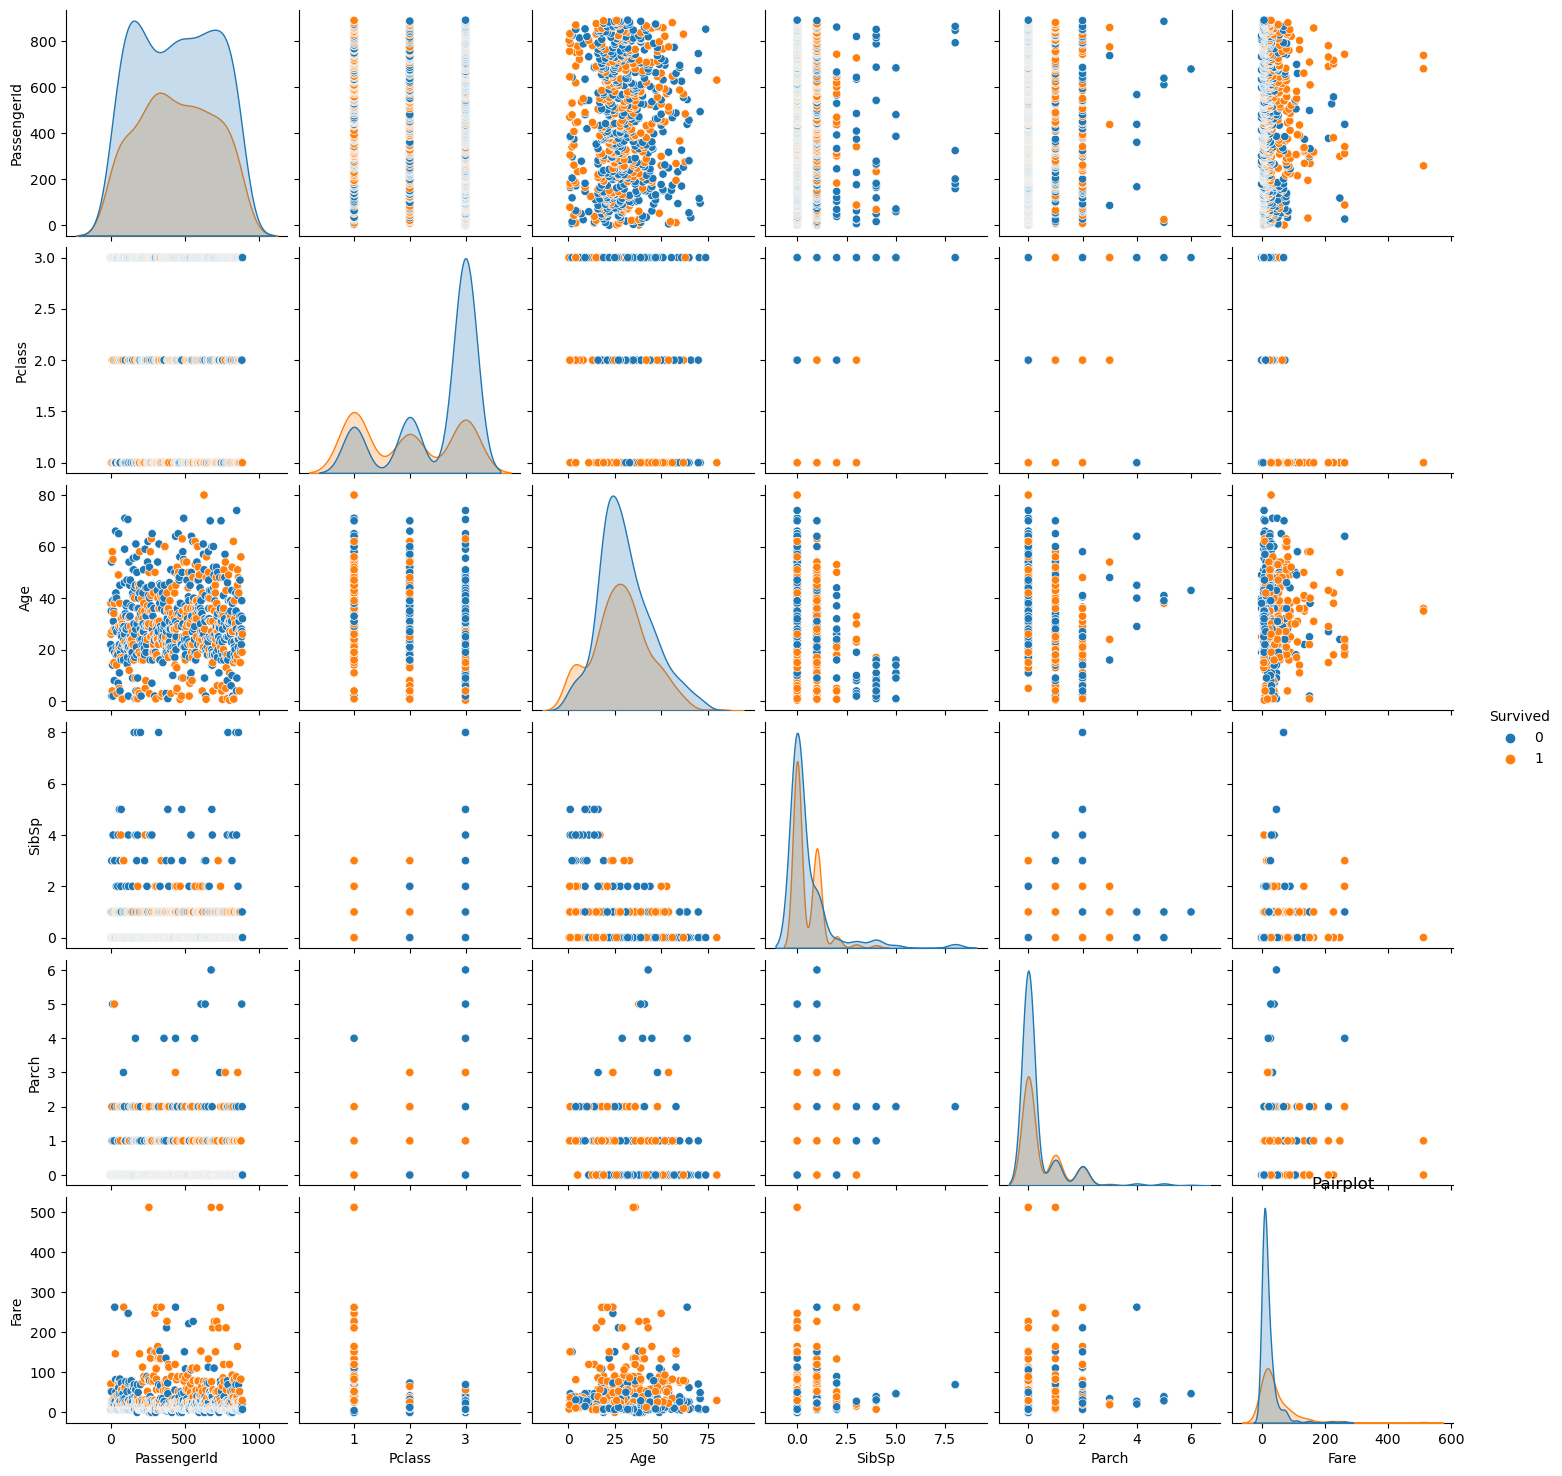

In [19]:
# вывод графиков
sns.pairplot(df_raw, hue='Survived')
plt.title('Pairplot')
plt.show()

In [20]:
# очислим от ненужных колонок
df_preproc = df_raw.drop(columns=['PassengerId','Name','Ticket'])
for col in ['Sex','Cabin','Embarked']:
    df_preproc[col] = df_preproc[col].astype(str)
task.upload_artifact(name='data.preproc', artifact_object=df_preproc)

train, test = train_test_split(df_preproc, test_size=0.33, random_state=42)
task.upload_artifact(name='data.train', artifact_object=train)
task.upload_artifact(name='data.test', artifact_object=test)

True

In [21]:
X_train = train.drop(columns=['Survived'])
y_train = train['Survived']

model = CatBoostClassifier(silent=True)
model.fit(X_train, y_train, cat_features=['Sex','Cabin','Embarked']);

ClearML Monitor: Reporting detected, reverting back to iteration based reporting


In [22]:
#cетка для перебора гиперпараметров
param_grid = {
    'depth': [4,5,6,7,8],
    'learning_rate': [0.1,0.05,0.01,0.005,0.001],
    'iterations': [30,50,100,150]
}

#формируем датасет для тестирования
X_test = test.drop(columns=['Survived'])
y_test = test['Survived']

#инциируем объект логирования
log = Logger.current_logger()

#переменные для хранения результатов
best_score = 0
best_model = None
i = 0


In [23]:
#перебираем случайные 50 гиперпараметров
for param in ParameterSampler(param_grid, n_iter=50, random_state=42):
    #обучаем модель
    model = CatBoostClassifier(**param, silent=True)
    model.fit(X_train, y_train, cat_features=['Sex','Cabin','Embarked'])

    #оцениваем модель
    test_scores = model.eval_metrics(
        data=Pool(X_test, y_test, cat_features=['Sex','Cabin','Embarked']),
        metrics=['Logloss','AUC'])
    test_logloss  = round(test_scores['Logloss'][-1], 4)
    test_roc_auc = round(test_scores['AUC'][-1]*100, 1)
    
    train_scores = model.eval_metrics(
        data=Pool(X_train, y_train, cat_features=['Sex','Cabin','Embarked']),
        metrics=['Logloss','AUC'])
    train_logloss  = round(train_scores['Logloss'][-1], 4)
    train_roc_auc = round(train_scores['AUC'][-1]*100, 1)

    #сравниваем текущий скор с лучшим
    if test_roc_auc > best_score:
        #сохраняем модель
        best_score = test_roc_auc
        best_model = model

        #записываем метрики в ClearML
        log.report_scalar("Logloss", "Test", iteration=i, value=test_logloss)
        log.report_scalar("Logloss", "Train", iteration=i, value=train_logloss)
        
        log.report_scalar("ROC AUC", "Test", iteration=i, value=test_roc_auc)
        log.report_scalar("ROC AUC", "Train", iteration=i, value=train_roc_auc)
        
        i+=1

In [24]:
#сохраним еще несколько параметров в виде констант:
log.report_single_value(name='Best ROC AUC', value=test_roc_auc)
log.report_single_value(name='Best Logloss', value=test_logloss)
log.report_single_value(name='Train Rows', value=X_train.shape[0])
log.report_single_value(name='Test Rows', value=X_test.shape[0])
log.report_single_value(name='Columns', value=X_train.shape[1])
log.report_single_value(name='Train Ratio', value=round(y_train.mean(),3))
log.report_single_value(name='Test Ratio', value=round(y_test.mean(),3))

In [25]:
#сохраним модель
best_model.save_model('my_model.cbm')

In [26]:
#завершим эксперимент
task.close()
